In [1]:
#/usr/local/bin/python3.8
import os
from astropy import table
from astropy.io import fits
import numpy as np
import glob
from scipy import signal
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import ellipsefits

In [2]:
def read_ellfits(ellfits):
    #efit=table.Table.read(ellfits)
    dataDict = ellipsefits.ReadEllipse(ellfits)
    efit = table.Table(dataDict.data, names=dataDict.colNames)
    return efit

In [36]:
def detectbar_m2(efit, pixscale=0.262, zp=22.5, sma_sb225=30):
    barindex1 = 0
    isoindex = 1
    bar_ell1, bar_pa1, bar_sma1, paoff1, pavar1, eloff1 = -99, -99, -99, -99, -99, -99

    # select half of radius
    # sid2 = ~np.isnan(ellperr)
    sid2 = (efit['grad_err'] != 0.0) & (efit['ellip_err'] != 0.0)
    sid = sid2.nonzero()[0]
    # print('sid2.sum()= ',sid2.sum())
    if (np.size(sid) == 0):
        return isoindex, barindex1, bar_ell1, bar_pa1, bar_sma1, paoff1, pavar1, eloff1
    
    if sid[0]<5: isoindex = 0
    efit = efit[sid]
    sma = efit['sma'] * pixscale
    ellp = efit['ellip']
    pa = efit['pa']

    nsize = sid2.sum()
    k = range(nsize - 1)
    # did = [i+1 for i in k]
    dellp = [(ellp[i + 1] - ellp[i]) for i in k]
    dpa = [(pa[i + 1] - pa[i]) for i in k]

    ellp_end = np.median(ellp[-5:-1])
    if ellp_end > 0.66:
        return isoindex, barindex1, bar_ell1, bar_pa1, bar_sma1, paoff1, pavar1, eloff1

    # find peaks in ellip profile
    peakind = signal.find_peaks(ellp, height=0., prominence=0.005, distance=5)
    if np.size(peakind[0]) == 0:
        return isoindex, barindex1, bar_ell1, bar_pa1, bar_sma1, paoff1, pavar1, eloff1

    peaks = ((peakind[0] > 3) * (peakind[0] < np.size(efit['sma']) - 5))
    # peakse = peakind[1]['peak_heights'] == np.max(peakind[1]['peak_heights'])
    peakse = (peakind[1]['peak_heights'] == np.max(peakind[1]['peak_heights'])) & (peakind[0]>3)
    peaks = peaks + peakse

    if peakind[0][peaks].size <= 0:
        return isoindex, barindex1, bar_ell1, bar_pa1, bar_sma1, paoff1, pavar1, eloff1
        
    paoff=[]
    pavar=[]
    eloff=[]
    elvar=[]
    paend=[]
    elend=[]
    barsma=[]
    barindex=[]
    #for j,i in enumerate(peakind[0]):
    for j,i in zip(peaks.nonzero()[0], peakind[0][peaks]):
        index=1
        print(j,i)
        #barend=(sma>sma[i])&(sma<sma[i]*1.5)
        #paoff0=np.abs(np.array(pa[barend]-pa[i])).max()
        #pavar0=np.abs(np.array(pa[int(i*1/3):i])-pa[i]).max() #np.std(np.array(pa[int(i*2/3):i]))
        #elloff0=np.abs(np.array(ellp[i]-ellp[barend])).max()
        
        #i=peakind[0][j]
        barleft1 = (sma<=sma[i]/3).nonzero()[0][-1] if (sma<=sma[i]/3).sum()>0 else 0
        barleft2 = barleft1 if peakind[0][j]-peakind[1]['left_bases'][j]<5 else peakind[1]['left_bases'][j]#
        barleft = np.max([barleft1, barleft2, peakind[0][j]-30])
        # print(barleft1, barleft2)
        try:
            if peakind[1]['right_bases'][j] < peakind[0][j+1]:
                peakright = peakind[1]['right_bases'][j]
            else:
                peakright = np.max([peakind[0][j+1], peakind[0][j]+10])
        except: 
            peakright = peakind[1]['right_bases'][j]
        #barright = np.min([int(i*1.5+1),np.size(sma)-1]) if sma[i]<sma[-1]*2/3 else np.size(sma)-1
        barright = np.min([i+15, int(i*1.5+1),np.size(sma)-1])
        barright = barright if peakright-peakind[0][j]<=10 else int(peakright)
        #barright = np.min([i+15, peakright, barright])
        
        #print('===>', i, barleft, barright, peakright)
        paoff0=np.abs(np.array(pa[i+1:barright+1]-pa[i-3:i+1][:, None])).max()
        pavar0=np.abs(np.array(pa[barleft:i-3])-pa[i-3]).max()
        elloff0=np.array(ellp[i]-ellp[i+1:barright+1]).max()
        ellvar0=np.array(ellp[i]-ellp[barleft:i]).max()
        num_dellp = (np.array(dellp[barleft:i]) < -0.001).sum()
        
        paend0 = pa[i]
        elend0 = ellp[i]
        barsma0 = sma[i]
        paoff.extend([paoff0])
        pavar.extend([pavar0])
        eloff.extend([elloff0])
        elvar.extend([ellvar0])
        paend.extend([paend0])
        elend.extend([elend0])
        barsma.extend([barsma0])
        
        el1 = elloff0 > 0.05
        el2 = (elend0 >= 0.25)\
            & (elend0 - peakind[1]['peak_heights'].max()<0.1)
        el3 = (ellvar0 >= 0.01)\
            & (num_dellp<5)\
            | ((elend0>0.5) & (elloff0>0.2))
        if (np.array(dellp[np.max([i-3,0]):i]).max()>0.2): index -= 2
    
        # pa1 = (paoff0 >= 10) & (paoff0 <= 170) & ((paoff0 > pavar0*1.5)|(pavar0>170))
        pa1 = (paoff0 >= 10) & (paoff0 <= 170) & ((paoff0 > pavar0*1.5)|(pavar0>170))
        pa1 = pa1 | ((paoff0 > pavar0*1.5) & (elloff0>0.2)) |((elend0>0.5)&(elloff0>0.2))
        pa2 = (pavar0 <= 21) |(pavar0>170) | (paoff0 > 2.5*pavar0) |((elend0>0.5)&(elloff0>0.2))
        sma1 = (barsma0 > 2.0)  #& (barsma0 < sma[-1]*2/3)
        if (elend0<0.36) & (barsma0>sma_sb225): index -= 2
        if (peakind[1]['prominences'][j] == peakind[1]['prominences'].max()) & (elend0>0.36): index += 1
        
        # index += np.array([(el1 & el2 & el3)*3 , (pa1 & pa2)*2 , sma1*1]).sum()
        index += np.array([el1, el2, el3, pa1, pa2, sma1]).sum()
        print(el1,el2, el3, pa1, pa2, sma1)
    
        barindex.extend([index])
    # pid = (barindex == np.max(barindex)).nonzero()[0][-1] 
    pid_maxi = (barindex == np.max(barindex)).nonzero()[0]
    if np.size(pid_maxi)>1:
        #pid_sma = np.array(barsma)[pid_maxi] < sma[-1]/2.
        pid_maxh = (peakind[1]['prominences'][pid_maxi] == np.max(peakind[1]['prominences'][pid_maxi])).nonzero()[0][0]
        pid = pid_maxi[pid_maxh]
        if (barsma[pid] > sma[-1]*0.66) & (np.max(peakind[1]['prominences'][pid_maxi]) < 0.1):
            pid = pid_maxi[0]
    else:
        pid = pid_maxi[0]
    barindex1 = barindex[pid]
    bar_ell1 = elend[pid]
    bar_pa1 = paend[pid]
    bar_sma1 = barsma[pid]
    paoff1 = paoff[pid]
    pavar1 = pavar[pid]
    eloff1 = eloff[pid]
    elvar1 = elvar[pid]
    return isoindex, barindex1, bar_ell1, bar_pa1, bar_sma1, paoff1, pavar1, eloff1

In [5]:
def getparcat(fn):
    parcat = table.Table.read('/Users/zhoupro/work/desi/SAG/data/SGA-2020.fits',1)
    imname = os.path.split(fn)[-1]
    galaxyname = imname[0:imname.find('-largegalaxy')]
    galaxyid = np.argwhere(parcat['GALAXY'] == galaxyname)
    try:
        sma_sb225 = parcat['SMA_SB22.5'][galaxyid[0][0]]
    except:
        sma_sb225 = 100
    return sma_sb225

In [ ]:
# example for barred galaxy

In [37]:
pixscale=0.262
zp=22.5
fn = '/Users/zhoupro/work/desi/SAG/checking/PGC1046776-largegalaxy-image-r_ell_tdump.txt' #PGC1105227
efit = read_ellfits(fn)
sma_sb225 = getparcat(fn)
result = detectbar_m2(efit, pixscale=0.262, zp=22.5, sma_sb225=sma_sb225)

pid, barindex, elend, paoff, barsma, paoff, pavar, eloff = result
print(' barindex =', barindex,'\n','elend = ', elend, '\n', 'barsma =', barsma, '\n',\
      'paoff = ', paoff, '\n', 'pavar = ', pavar, '\n', 'eloff = ', eloff)


0 10
===> 10 0 26 26
False False True True True False
1 82
===> 82 52 97 92
True True True True True True
2 110
===> 110 92 124 124
True True True True True True
 barindex = 8 
 elend =  0.4594058 
 barsma = 8.979863980000001 
 paoff =  78.15499000000001 
 pavar =  5.097440000000006 
 eloff =  0.36355679999999996


In [38]:
#efit=table.Table.read(ellfits)
sma=efit['sma']*pixscale
print(sma.max(), sma.size)
ellperr=efit['ellip_err'] 

#select half of radius
#sid1=sma<=sma.max()/2
#sid2=~np.isnan(ellperr)
sid2 = (efit['grad_err'] != 0.0) & (efit['ellip_err'] != 0.0)
sid = sid2.nonzero()[0]

nsize = sid2.sum()
efit=efit[sid]
sma=efit['sma']*pixscale
intens=efit['intens']
intmag= -2.5*np.log10(intens/pixscale/pixscale)+zp
intmagerr=2.5/np.log(10)*efit['int_err']/intens
ellp=efit['ellip']
ellperr=efit['ellip_err'] 
pa=efit['pa']
paerr=efit['pa_err']
ellp_end = np.median(ellp[-5:-1])
print(sma.max(),nsize)
if sid[0]>5: print("bad fitting !")
    
k=range(nsize-1)
#did = [i+1 for i in k]
dellp=[(ellp[i+1]-ellp[i]) for i in k]
dpa =[(pa[i+1]-pa[i]) for i in k]

peakind = signal.find_peaks(ellp,height=0.,prominence=0.005, distance=5)
peakind_pa = signal.find_peaks(pa,height=0.,prominence=1,distance=5)
print(np.size(peakind[0]))
peaks=((peakind[0]>3) * (peakind[0]<np.size(efit['sma'])-5) )
peakse = (peakind[1]['peak_heights'] == np.max(peakind[1]['peak_heights']))&(peakind[0]>3)
peaks = peaks + peakse
ab = peakind[0][peaks]
peakind, peaks, np.size(ellp), peakind_pa

36.02623140000001 130
32.9691106 126
3


((array([ 10,  82, 110]),
  {'peak_heights': array([0.05054684, 0.4594058 , 0.300235  ]),
   'prominences': array([0.01000207, 0.3635568 , 0.1410928 ]),
   'left_bases': array([ 7, 26, 92]),
   'right_bases': array([ 26,  92, 124])}),
 array([ True,  True,  True]),
 126,
 (array([  3,  91, 105, 122]),
  {'peak_heights': array([ 79.95255, 155.16631,  77.24779,  75.83109]),
   'prominences': array([ 1.57586, 77.80313,  1.71503,  6.96245]),
   'left_bases': array([  1,   1, 102, 113]),
   'right_bases': array([  4, 124, 124, 124])}))

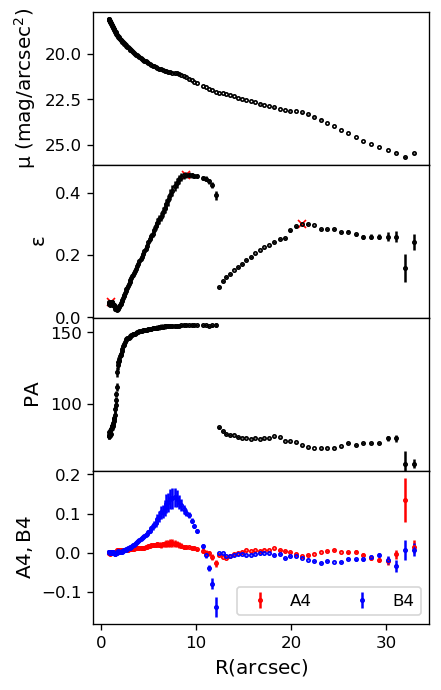

In [39]:
import matplotlib.pyplot as plt
import matplotlib
from astropy.visualization import simple_norm
#efit=table.Table.read(ellfits)
pix = pixscale
sma=efit['sma']*pixscale
intens=efit['intens']
intmag= -2.5*np.log10(intens/pix/pix)+zp
intmagerr=2.5/np.log(10)*efit['int_err']/intens
intmagerr = np.abs(intmagerr)
ellp=efit['ellip']
ellperr=efit['ellip_err'] 
pa=efit['pa']
paerr=efit['pa_err']  
a4=efit['a4']  
a4err=efit['a4_err'] 
b4=efit['b4']  
b4err=efit['b4_err'] 

fig, ax = plt.subplots(ncols=1,nrows=4,figsize = (4,6), dpi=120,sharex=True)
plt.subplots_adjust(left= 0.2,right=0.9,bottom=0.1,top=0.95,hspace=0) #wspace=0
ax[0].errorbar(sma,intmag,yerr=intmagerr,fmt='o',markeredgecolor='k',markerfacecolor='none',markersize=2,ecolor='k')
ax[0].set_ylabel(r'$\mathrm{\mu\ (mag/arcsec^{2})}$',fontsize=12)
ax[0].invert_yaxis()  
ax[1].errorbar(sma,ellp,yerr=ellperr,fmt='o',markeredgecolor='k',markerfacecolor='none',markersize=2,ecolor='k')
ax[1].set_ylabel(r'$\mathrm{\epsilon}$',fontsize=12)
ax[1].plot(sma[peakind[0][peaks]],ellp[peakind[0][peaks]],'rx',markersize=5)
ax[2].errorbar(sma,pa,yerr=paerr,fmt='o',markeredgecolor='k',markerfacecolor='none',markersize=2,ecolor='k')
#ax[2].plot(sma[peakind_pa[0]],pa[peakind_pa[0]],'ro',markersize=10)
ax[2].set_ylabel(r'$\mathrm{PA}$',fontsize=12)
ax[3].errorbar(sma,a4,yerr=a4err,fmt='o',markeredgecolor='r',markerfacecolor='none',markersize=2,label='A4',ecolor='r')
ax[3].errorbar(sma,b4,yerr=b4err,fmt='o',markeredgecolor='b',markerfacecolor='none',markersize=2,label='B4',ecolor='b')
ax[3].set_ylabel(r'$\mathrm{A4,B4}$',fontsize=12)
ax[3].set_xlabel(r'$\mathrm{R (arcsec)}$',fontsize=12)
#ax[3].set_ylim([-0.5,0.5])
ax[2].set_ylim([np.min(pa)-5,np.max(pa)+5])
ax[3].legend(ncol=2)


In [ ]:
# example for non-barred galaxy

In [42]:
pixscale=0.262
zp=22.5
fn = '/Users/zhoupro/work/desi/SAG/checking/PGC000010-largegalaxy-image-r_ell_tdump.txt' 
efit = read_ellfits(fn)
sma_sb225 = getparcat(fn)
result = detectbar_m2(efit, pixscale=0.262, zp=22.5, sma_sb225=sma_sb225)

pid, barindex, elend, paoff, barsma, paoff, pavar, eloff = result
print(' barindex =', barindex,'\n','elend = ', elend, '\n', 'barsma =', barsma, '\n',\
      'paoff = ', paoff, '\n', 'pavar = ', pavar, '\n', 'eloff = ', eloff)


0 25
===> 25 1 39 39
True False True True True False
1 39
===> 39 33 62 62
True False True False False True
2 69
===> 69 62 84 75
False False True True True True
 barindex = 3 
 elend =  0.1428524 
 barsma = 1.660874592 
 paoff =  104.27232000000001 
 pavar =  19.104049999999997 
 eloff =  0.13353923699999998


In [43]:
#efit=table.Table.read(ellfits)
sma=efit['sma']*pixscale
print(sma.max(), sma.size)
ellperr=efit['ellip_err'] 

#select half of radius
#sid1=sma<=sma.max()/2
#sid2=~np.isnan(ellperr)
sid2 = (efit['grad_err'] != 0.0) & (efit['ellip_err'] != 0.0)
sid = sid2.nonzero()[0]

nsize = sid2.sum()
efit=efit[sid]
sma=efit['sma']*pixscale
intens=efit['intens']
intmag= -2.5*np.log10(intens/pixscale/pixscale)+zp
intmagerr=2.5/np.log(10)*efit['int_err']/intens
ellp=efit['ellip']
ellperr=efit['ellip_err'] 
pa=efit['pa']
paerr=efit['pa_err']
ellp_end = np.median(ellp[-5:-1])
print(sma.max(),nsize)
if sid[0]>5: print("bad fitting !")
    
k=range(nsize-1)
#did = [i+1 for i in k]
dellp=[(ellp[i+1]-ellp[i]) for i in k]
dpa =[(pa[i+1]-pa[i]) for i in k]

peakind = signal.find_peaks(ellp,height=0.,prominence=0.005, distance=5)
peakind_pa = signal.find_peaks(pa,height=0.,prominence=1,distance=5)
print(np.size(peakind[0]))
peaks=((peakind[0]>3) * (peakind[0]<np.size(efit['sma'])-5) )
peakse = (peakind[1]['peak_heights'] == np.max(peakind[1]['peak_heights']))&(peakind[0]>3)
peaks = peaks + peakse
ab = peakind[0][peaks]
peakind, peaks, np.size(ellp), peakind_pa

12.76745912 95
12.76745912 95
4


((array([25, 39, 69, 90]),
  {'peak_heights': array([0.1428524 , 0.08592915, 0.04341185, 0.1048124 ]),
   'prominences': array([0.09244353, 0.07661599, 0.01878289, 0.06208515]),
   'left_bases': array([ 1, 33, 62, 62]),
   'right_bases': array([62, 62, 75, 93])}),
 array([ True,  True,  True, False]),
 95,
 (array([ 8, 34, 59, 78, 86]),
  {'peak_heights': array([ 27.30464  , 140.28366  , 138.9696   , 148.16099  , 179.3863485]),
   'prominences': array([  1.36072  ,  61.18301  ,   7.64775  ,   6.28668  , 171.2410265]),
   'left_bases': array([ 0,  0, 52,  0, 85]),
   'right_bases': array([ 9, 65, 65, 79, 87])}))

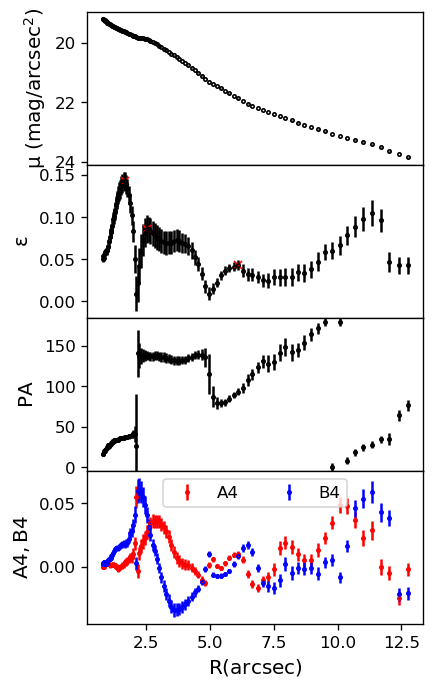

In [44]:
import matplotlib.pyplot as plt
import matplotlib
from astropy.visualization import simple_norm
#efit=table.Table.read(ellfits)
pix = pixscale
sma=efit['sma']*pixscale
intens=efit['intens']
intmag= -2.5*np.log10(intens/pix/pix)+zp
intmagerr=2.5/np.log(10)*efit['int_err']/intens
intmagerr = np.abs(intmagerr)
ellp=efit['ellip']
ellperr=efit['ellip_err'] 
pa=efit['pa']
paerr=efit['pa_err']  
a4=efit['a4']  
a4err=efit['a4_err'] 
b4=efit['b4']  
b4err=efit['b4_err'] 

fig, ax = plt.subplots(ncols=1,nrows=4,figsize = (4,6), dpi=120,sharex=True)
plt.subplots_adjust(left= 0.2,right=0.9,bottom=0.1,top=0.95,hspace=0) #wspace=0
ax[0].errorbar(sma,intmag,yerr=intmagerr,fmt='o',markeredgecolor='k',markerfacecolor='none',markersize=2,ecolor='k')
ax[0].set_ylabel(r'$\mathrm{\mu\ (mag/arcsec^{2})}$',fontsize=12)
ax[0].invert_yaxis()  
ax[1].errorbar(sma,ellp,yerr=ellperr,fmt='o',markeredgecolor='k',markerfacecolor='none',markersize=2,ecolor='k')
ax[1].set_ylabel(r'$\mathrm{\epsilon}$',fontsize=12)
ax[1].plot(sma[peakind[0][peaks]],ellp[peakind[0][peaks]],'rx',markersize=5)
ax[2].errorbar(sma,pa,yerr=paerr,fmt='o',markeredgecolor='k',markerfacecolor='none',markersize=2,ecolor='k')
#ax[2].plot(sma[peakind_pa[0]],pa[peakind_pa[0]],'ro',markersize=10)
ax[2].set_ylabel(r'$\mathrm{PA}$',fontsize=12)
ax[3].errorbar(sma,a4,yerr=a4err,fmt='o',markeredgecolor='r',markerfacecolor='none',markersize=2,label='A4',ecolor='r')
ax[3].errorbar(sma,b4,yerr=b4err,fmt='o',markeredgecolor='b',markerfacecolor='none',markersize=2,label='B4',ecolor='b')
ax[3].set_ylabel(r'$\mathrm{A4,B4}$',fontsize=12)
ax[3].set_xlabel(r'$\mathrm{R (arcsec)}$',fontsize=12)
#ax[3].set_ylim([-0.5,0.5])
ax[2].set_ylim([np.min(pa)-5,np.max(pa)+5])
ax[3].legend(ncol=2)
